In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision import models

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(torch.cuda.is_available())

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

c:\Users\user\anaconda3\envs\convae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
True
학습을 진행하는 기기: cuda:0


In [2]:
args = {
	'BATCH_SIZE': 4,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 20,
    'IMG_SIZE': 700
        }

src = 'D:/abnormal_detection_dataset/mvtec_anomaly_detection/metal_nut/train/good/'

In [3]:
# 이미지 읽기
def img_read(src, file):
    img = cv2.imread(src+file, cv2.COLOR_BGR2GRAY)
    return img

# src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(src)

X = []
Y = []

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.
for file in files:
    X.append(img_read(src,file)/255.)
    Y.append(1) # nomal label : 1

# array로 데이터 변환
X = np.array(X)
Y = np.array(Y)

print('Normal shape:',np.shape(X))
print(X.shape)
print(Y.shape)

# Train set, Test set으로 나누기
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=1,shuffle=True)

# 형태를 3차원에서 2차원으로 변경, 첫 번째 인덱스 : 이미지 수, 두 번쨰 인덱스 : 2차원 이미지를 1차원으로 변경 후의 길이
# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
# X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(np.shape(X_train))
print(np.shape(X_test))
print(X_train.shape)
print(Y_train.shape)

Normal shape: (220, 700, 700, 3)
(220, 700, 700, 3)
(220,)
(176, 700, 700, 3)
(44, 700, 700, 3)
(176, 700, 700, 3)
(176,)


In [4]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)

X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

In [5]:
# X_train = X_train.unsqueeze(dim=1)
# X_test = X_test.unsqueeze(dim=1)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

torch.Size([176, 700, 700, 3])
torch.Size([44, 700, 700, 3])
torch.Size([176])
torch.Size([44])


In [6]:
# X_train.permute()

In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X_train
        self.Y = Y_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        labels = self.Y[idx]
        return img, labels
    
    # def sort(self, X_train, X_test):
    #     X_train.shape = X_train.permute(0, 3, 1, 2).shape
    #     X_test.shape = X_test.permute(0, 3, 1, 2).shape
    #     return X_train, X_test

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        # Encoder # (args['BATCH_SIZE'], 1, args['IMG_SIZE'], args['IMG_SIZE'])
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)

        return output

In [8]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

train_dataset = CustomDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=args['BATCH_SIZE'], shuffle=True, num_workers=0)

test_dataset = CustomDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=args['BATCH_SIZE'], shuffle=False, num_workers=0)

model = ConvAutoEncoder()
model.to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

summary(model)

Layer (type:depth-idx)                   Param #
ConvAutoEncoder                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─ConvTranspose2d: 2-7              8,224
│    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
│    └─ConvTranspose2d: 2-9              387
│    └─Sigmoid: 2-10                     --
Total params: 28,003
Trainable params: 28,003
Non-trainable params: 0

In [9]:
print(X_train.shape)

torch.Size([176, 3, 700, 700])


In [10]:
steps = 0
total_steps = len(train_loader)
for epoch in range(args['NUM_EPOCH']):
    running_loss = 0
    for i, (X_train, _) in enumerate(train_loader):
        steps += 1

        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item() * X_train.shape[0]

        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch + 1, args['NUM_EPOCH']),
                  'Training loss: {:.5f}..'.format(running_loss / total_steps))

            steps = 0
            running_loss = 0
            model.train()

Epoch: 1/20 Training loss: 0.27782..
Epoch: 2/20 Training loss: 0.01462..
Epoch: 3/20 Training loss: 0.00615..
Epoch: 4/20 Training loss: 0.00470..
Epoch: 5/20 Training loss: 0.00399..
Epoch: 6/20 Training loss: 0.00349..
Epoch: 7/20 Training loss: 0.00301..
Epoch: 8/20 Training loss: 0.00271..
Epoch: 9/20 Training loss: 0.00248..
Epoch: 10/20 Training loss: 0.00228..
Epoch: 11/20 Training loss: 0.00214..
Epoch: 12/20 Training loss: 0.00204..
Epoch: 13/20 Training loss: 0.00198..
Epoch: 14/20 Training loss: 0.00192..
Epoch: 15/20 Training loss: 0.00187..
Epoch: 16/20 Training loss: 0.00183..
Epoch: 17/20 Training loss: 0.00180..
Epoch: 18/20 Training loss: 0.00177..
Epoch: 19/20 Training loss: 0.00175..
Epoch: 20/20 Training loss: 0.00172..


In [11]:
torch.save(model.state_dict(), './ae1.pth')

In [12]:
print(X_train.shape)

torch.Size([4, 3, 700, 700])


In [13]:
# print(X_train.permute(0, 3, 1, 2).shape)

In [14]:
#torch.save(model.state_dict(), './ae1.pth')

net = ConvAutoEncoder()
net.load_state_dict(torch.load('./ae1.pth'))

print(net.parameters)

<bound method Module.parameters of ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)>


In [19]:
preds = []
with torch.no_grad():
    val_loss = 0.0
    for val_input in X_test:
        val_output = model(val_input)
        preds.append(val_output)
        v_loss = criterion(val_output, val_input)
        val_loss += v_loss
        # print('preds: ', preds[0].shape) # torch.Size([3, 700, 700])
        # print('X_test: ', X_test[0].shape) # torch.Size([3, 700, 700])
        # print('val_out: ', val_output1.shape) # torch.Size([3, 700, 700])
    print('valdation loss {}'.format(val_loss))

valdation loss 0.018900344148278236


TypeError: Invalid shape (3, 700, 700) for image data

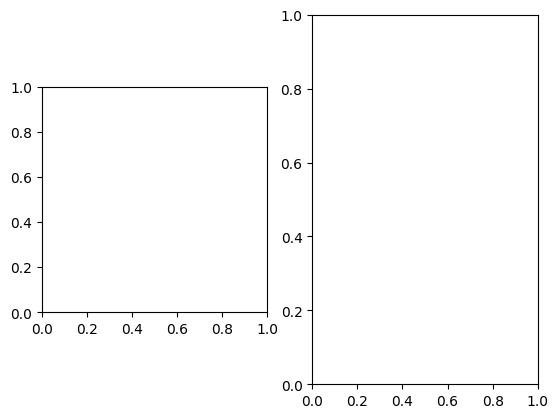

In [63]:
# Get the model output
with torch.no_grad():
    test_image= X_test[0]
    output = model(test_image.unsqueeze(0))

# Convert the output to a numpy array
output = output.squeeze().detach().cpu().numpy()

# Plot the test image and the model output
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test_image.permute(1, 2, 0))
ax1.set_title('Test Image')
ax2.imshow(output.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
ax2.set_title('Model Output')
plt.show()

RuntimeError: shape '[700, 700]' is invalid for input of size 1470000

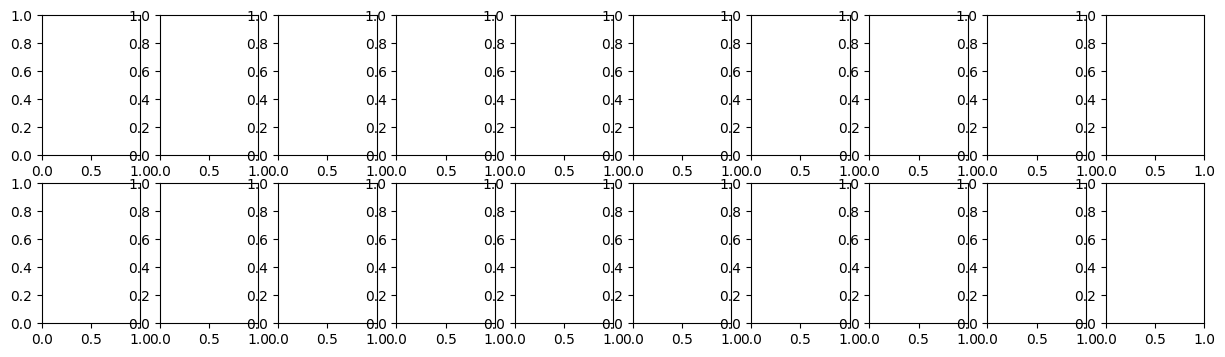

In [58]:
sample_size = 10

test_sample, pred_sample = [], []

with torch.no_grad():
    fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
    # plt.title('reconstruct')
    for i in range(sample_size):

        val_input1 = X_test[i]
        for val_input1 in X_test:
            val_output1 = model(val_input1)
            test_sample.append(val_input1)
            pred_sample.append(val_output1)
            
            org_img1 = (test_sample[i].reshape(700, 700)).argmax(1).cpu().numpy()
            rec_img1 = (pred_sample[i].reshape(700, 700)).argmax(1).cpu().numpy()
            print(org_img1.shape)
            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
            ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)
    plt.show()

In [ ]:
#### 다른 데이터셋으로 테스ㅡㅌ
test_path = 'D:/abnormal_detection_dataset/mvtec_anomaly_detection/metal_nut/test/custom/'

def img_read(src, file):
    img = cv2.imread(src+file, cv2.COLOR_BGR2GRAY)
    return img

# src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(test_path)

test_X = []
test_Y = []

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.
for file in files:
    test_X.append(img_read(test_path,file)/255.)
    test_Y.append(1) # nomal label : 1

# array로 데이터 변환
test_X = np.array(test_X)
test_Y = np.array(test_Y)

print('Normal shape:',np.shape(test_X))
print(test_X.shape)
print(test_Y.shape)

print(np.shape(test_X))
print(np.shape(test_Y))


test_X = torch.Tensor(test_X)

# test_X = test_X.unsqueeze(dim=1)
print(test_X.shape) #torch.Size([2400, 1, 1, 56, 56])

print(test_X.shape)


test_Y = torch.Tensor(test_Y)
print(test_Y.shape)

In [ ]:
preds = []
with torch.no_grad():
    val_loss = 0.0
    for val_input in test_X:
        val_output = model(val_input)
        preds.append(val_output)
        v_loss = criterion(val_output, test_X)
        val_loss += v_loss
    print('valdation loss {}'.format(val_loss))

sample_size = 10

test_sample1, pred_sample1 = [], []

with torch.no_grad():
    fig, ax = plt.subplots(2, sample_size, figsize=(15, 4))
    for i in range(sample_size):

        val_input1 = test_X[i]
        for val_input1 in test_X:
            val_output1 = model(val_input1)
            test_sample1.append(val_input1)
            pred_sample1.append(val_output1)

            org_img1 = test_sample1[i].reshape(700, 700)
            rec_img1 = pred_sample1[i].reshape(700, 700)

            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(org_img1, cmap=plt.cm.bone)
            ax[1][i].imshow(rec_img1, cmap=plt.cm.bone)
    plt.show()

NameError: name 'test_X' is not defined